In [9]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pylab as pl
import shapely
import os
import statsmodels as stm
import urllib2
import urllib
import StringIO
import ast
from datetime import datetime, timedelta
import time
import io
import json
import requests
import shutil
import datetime as dt
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
from sklearn import preprocessing
import statsmodels.formula.api as smf
import pytz as pytz

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


---

# WEATHER

In [13]:
# Downloadind the weather data - don't run again
#!unzip "DarkSky_Data.zip"

Archive:  DarkSky_Data.zip
  inflating: DarkSky_Data.json       


In [2]:
# Reading in the weather 

weather = pd.read_json("DarkSky_Data.json")

In [3]:
weather.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,visibility,windBearing,windSpeed
0,26.80,0.82,28.43,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1009.73,Mostly Cloudy,32.48,1136091600,8.84,335.0,6.00
1,27.04,0.77,28.32,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1010.35,Mostly Cloudy,32.33,1136095200,7.67,345.0,5.49
2,27.21,0.78,28.34,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1011.40,Mostly Cloudy,32.29,1136098800,8.69,344.0,5.23
3,27.01,0.34,27.97,0.84,partly-cloudy-night,NaN,0.0,0.0,NaN,1012.17,Partly Cloudy,32.19,1136102400,8.79,345.0,5.32
4,26.65,0.95,28.10,0.85,cloudy,NaN,0.0,0.0,NaN,1012.67,Overcast,32.00,1136106000,8.41,339.0,5.49


In [4]:
# # Adding datetime column to weather data

weather['datetime'] = pd.to_datetime(weather['time'], unit='s', utc=True)

In [10]:
# Adjusting the datetime for timezone 

tz = pytz.timezone('America/New_York')

adjustDateTime = []
for i in range(len(weather)):
    adjustDateTime.append(weather['datetime'][i].tz_localize(pytz.utc).tz_convert(tz).tz_localize(None))

In [11]:
# Adding the adjusted column

weather['datetime_adj'] = adjustDateTime

In [12]:
# Reweather.head()

In [13]:
# Removing duplicated rows

weather = weather.drop_duplicates(subset=['datetime_adj'])

---

# CRIME

In [8]:
## Downloading the crime data -- very large, don't run again

#!wget "https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD"

--2018-02-12 22:32:08--  https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD
Resolving data.cityofnewyork.us... 52.206.140.205
Connecting to data.cityofnewyork.us|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: “rows.csv?accessType=DOWNLOAD”

    [               <=>                   ] 1,427,270,109 2.71M/s   in 10m 33s 

Last-modified header invalid -- time-stamp ignored.
2018-02-12 22:42:43 (2.15 MB/s) - “rows.csv?accessType=DOWNLOAD” saved [1427270109]



In [15]:
# Reading in the crime data

crimeData = pd.read_csv("rows.csv_accessType=DOWNLOAD")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
# Looking through the columns

crimeData.columns

Index([u'CMPLNT_NUM', u'CMPLNT_FR_DT', u'CMPLNT_FR_TM', u'CMPLNT_TO_DT',
       u'CMPLNT_TO_TM', u'RPT_DT', u'KY_CD', u'OFNS_DESC', u'PD_CD',
       u'PD_DESC', u'CRM_ATPT_CPTD_CD', u'LAW_CAT_CD', u'JURIS_DESC',
       u'BORO_NM', u'ADDR_PCT_CD', u'LOC_OF_OCCUR_DESC', u'PREM_TYP_DESC',
       u'PARKS_NM', u'HADEVELOPT', u'X_COORD_CD', u'Y_COORD_CD', u'Latitude',
       u'Longitude', u'Lat_Lon'],
      dtype='object')

In [17]:
crimeData.tail()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
5580030,582350583,01/01/2015,03:50:00,01/01/2016,04:00:00,01/01/2016,105,ROBBERY,399.0,"ROBBERY,COMMERCIAL UNCLASSIFIED",...,30.0,INSIDE,HOTEL/MOTEL,NaN,NaN,998372.0,240146.0,40.825818,-73.948975,"(40.825817778, -73.948974825)"
5580031,258046495,01/01/2015,01:25:00,01/01/2016,01:30:00,01/01/2016,578,HARRASSMENT 2,638.0,"HARASSMENT,SUBD 3,4,5",...,41.0,NaN,TRANSIT - NYC SUBWAY,NaN,NaN,1014468.0,238156.0,40.820315,-73.890825,"(40.820315396, -73.890824603)"
5580032,640212578,01/01/2015,00:30:00,01/01/2016,00:40:00,01/01/2016,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",...,109.0,FRONT OF,BAR/NIGHT CLUB,NaN,NaN,1030529.0,214093.0,40.754199,-73.832963,"(40.754199468, -73.832962523)"
5580033,496500431,06/30/2014,12:00:00,12/29/2015,12:00:00,01/01/2016,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,...,50.0,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1009735.0,261272.0,40.883777,-73.907837,"(40.883776851, -73.907836928)"
5580034,256379572,12/31/2001,16:00:00,01/01/2016,10:50:00,01/01/2016,107,BURGLARY,213.0,"BURGLARY,COMMERCIAL,NIGHT",...,84.0,INSIDE,PUBLIC SCHOOL,NaN,NaN,989682.0,188334.0,40.683617,-73.980416,"(40.683616638, -73.980416007)"


In [18]:
# Filtering down to complaint dates between 01/01/2006 - 12/31/2017

crimeData['year'] = crimeData['CMPLNT_FR_DT'].str[-4:].fillna(0).astype(int)
crimeData['hour'] = crimeData['CMPLNT_FR_TM'].str[:2].fillna(0).astype(int)
crime = crimeData[((crimeData['year'] > 2005) & (crimeData['hour'] < 24))]

# Creating datetime column

crime['datetime'] = pd.to_datetime((crime['CMPLNT_FR_DT'] + ' ' + crime['CMPLNT_FR_TM']), format='%m/%d/%Y %H:%M:%S')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
# dropping NaNs from datetime

crime = crime.dropna(axis=0, subset=['datetime'])
crime = crime.reset_index()

In [20]:
# Rounding to the nearest hour

def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

crimeRound = []

for i in range(len(crime)):
     t = crime['datetime'][i]
     crimeRound.append(hour_rounder(t)) 

In [21]:
# Adding the rounded datetime to the dataframe

crime['datetime_round'] = crimeRound

In [22]:
crime.head()

,index,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,year,hour,datetime,datetime_round
0,0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,...,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)",2015,23,2015-12-31 23:45:00,2016-01-01 00:00:00
1,1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)",2015,23,2015-12-31 23:36:00,2016-01-01 00:00:00
2,2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,...,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)",2015,23,2015-12-31 23:30:00,2016-01-01 00:00:00
3,3,968417082,12/31/2015,23:30:00,NaN,NaN,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,NaN,1060183.0,177862.0,40.654549,-73.726339,"(40.654549444, -73.726338791)",2015,23,2015-12-31 23:30:00,2016-01-01 00:00:00
4,4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,NaN,987606.0,208148.0,40.738002,-73.987891,"(40.7380024, -73.98789129)",2015,23,2015-12-31 23:25:00,2015-12-31 23:00:00


In [23]:
# Unique crime types

crimeData.OFNS_DESC.unique()

array(['FORGERY', 'MURDER & NON-NEGL. MANSLAUGHTER', 'DANGEROUS DRUGS',
       'ASSAULT 3 & RELATED OFFENSES', 'FELONY ASSAULT',
       'DANGEROUS WEAPONS', 'PETIT LARCENY', 'GRAND LARCENY', 'ROBBERY',
       'OFFENSES AGAINST PUBLIC ADMINI', 'CRIMINAL MISCHIEF & RELATED OF',
       'RAPE', 'INTOXICATED & IMPAIRED DRIVING', 'HARRASSMENT 2',
       'SEX CRIMES', 'BURGLARY', 'CRIMINAL TRESPASS',
       'MISCELLANEOUS PENAL LAW', 'VEHICLE AND TRAFFIC LAWS',
       'OFF. AGNST PUB ORD SENSBLTY &', 'FRAUDS',
       'GRAND LARCENY OF MOTOR VEHICLE', 'OFFENSES INVOLVING FRAUD',
       'OFFENSES AGAINST THE PERSON', 'FRAUDULENT ACCOSTING',
       'OTHER OFFENSES RELATED TO THEF', 'GAMBLING', 'ARSON',
       'POSSESSION OF STOLEN PROPERTY', 'UNAUTHORIZED USE OF A VEHICLE',
       'THEFT-FRAUD', 'DISORDERLY CONDUCT', nan, 'ADMINISTRATIVE CODE',
       'CHILD ABANDONMENT/NON SUPPORT', 'OTHER STATE LAWS (NON PENAL LA',
       'NYS LAWS-UNCLASSIFIED FELONY', "BURGLAR'S TOOLS",
       'THEFT OF SERV

---

# Merging the Data

In [24]:
df = crime.merge(weather, how='left', left_on="datetime_round", right_on="datetime_adj")

In [25]:
# Confirming that the new dataframe is the same length as the crime dataframe

print("left merge:", len(df) - len(crime))

left merge: 0


In [172]:
df.columns

Index([              u'index',          u'CMPLNT_NUM',        u'CMPLNT_FR_DT',
              u'CMPLNT_FR_TM',        u'CMPLNT_TO_DT',        u'CMPLNT_TO_TM',
                    u'RPT_DT',               u'KY_CD',           u'OFNS_DESC',
                     u'PD_CD',             u'PD_DESC',    u'CRM_ATPT_CPTD_CD',
                u'LAW_CAT_CD',          u'JURIS_DESC',             u'BORO_NM',
               u'ADDR_PCT_CD',   u'LOC_OF_OCCUR_DESC',       u'PREM_TYP_DESC',
                  u'PARKS_NM',          u'HADEVELOPT',          u'X_COORD_CD',
                u'Y_COORD_CD',            u'Latitude',           u'Longitude',
                   u'Lat_Lon',                u'year',                u'hour',
                u'datetime_x',      u'datetime_round', u'apparentTemperature',
                u'cloudCover',            u'dewPoint',            u'humidity',
                      u'icon',  u'precipAccumulation',     u'precipIntensity',
         u'precipProbability',          u'precipType

In [282]:
df = df.round({'dewPoint':0, 'apparentTemperature':0, 'temperature': 0, 'visibility': 1, 
               'windBearing': 0, 'windSpeed': 0, 'pressure':0, 'precipAccumulation':2 })

In [283]:
# Reducing df to the 7 major felony types

sevenFelonies = ['ROBBERY', 'FELONY ASSAULT', 'MURDER & NON-NEGL. MANSLAUGHTER', 'GRAND LARCENY', 'BURGLARY',
                 'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE']
dfSeven = df.loc[df['OFNS_DESC'].isin(sevenFelonies)].reset_index()

# Plotting the data

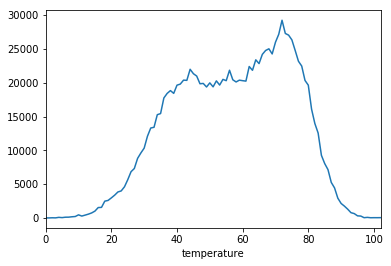

In [129]:
dfSeven.groupby('temperature').size().plot();

In [147]:
dfCrimesByTemp = dfSeven.groupby('temperature').size()
dfCrimesByTemp = pd.DataFrame(dfCrimesByTemp).reset_index()
dfCrimesByTemp.columns = ['Temperature', 'Count_crime']
dfCrimesByTemp.head()

,Temperature,Count_crime
0,0.0,4
1,1.0,3
2,2.0,23
3,3.0,12
4,4.0,86


In [148]:
dfTempNorm = dfSeven.groupby(['temperature','datetime_adj']).size()
dfTempNorm = pd.DataFrame(dfTempNorm).reset_index()
dfTempByHour = dfTempNorm.groupby('temperature').size()
dfTempByHour = pd.DataFrame(dfTempByHour).reset_index()
dfTempByHour.columns = ['Temperature', 'Count_hour']
dfTempByHour.head()

,Temperature,Count_hour
0,0.0,1
1,1.0,1
2,2.0,4
3,3.0,3
4,4.0,12


In [149]:
dfTempNormalized = pd.merge(dfTempByHour, dfCrimesByTemp, on='Temperature')

In [152]:
dfTempNormalized['avgCrimePerHour'] = dfTempNormalized.Count_crime / dfTempNormalized.Count_hour

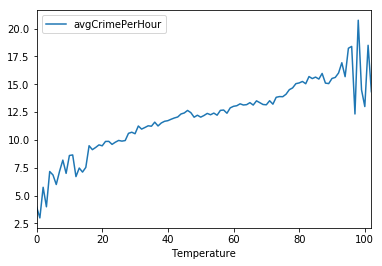

In [156]:
dfTempNormalized.plot('Temperature', 'avgCrimePerHour')

In [157]:
tempMod = smf.ols("avgCrimePerHour ~ Temperature", data=dfTempNormalized)
tempFit = tempMod.fit()
tempFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        avgCrimePerHour   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     630.0
Date:                Sun, 08 Apr 2018   Prob (F-statistic):           3.32e-45
Time:                        16:20:03   Log-Likelihood:                -164.10
No. Observations:                 103   AIC:                             332.2
Df Residuals:                     101   BIC:                             337.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       6.9062      0.235     29.367      0.000         6.440     7.373
Temperature     0.1000      0.004     25.099      0.000         0.092     0.108
==============================================================================
Omnibus:                       33.966   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.103
Skew:                          -1.177   Prob(JB):                     7.39e-20
Kurtosis:                       6.872   Cond. No.                         117.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

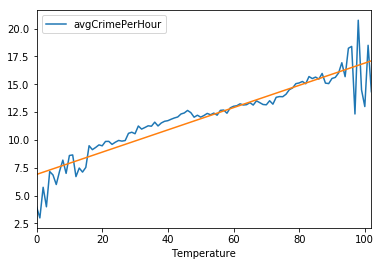

In [163]:
dfTempNormalized.plot('Temperature', 'avgCrimePerHour')
tempFitLine = tempFit.fittedvalues
pl.plot(tempFitLine);

In [284]:
# Defining our formula

def weatherCorrelation (dataframe, crime, weatherType):
    """Does all of the above, but allows us to specify the specific crime type and weather type"""
    
    # Reducing dataframe based on selected crime type (listing no crime yields all results
    if crime == 'ALL CRIME':
        dataframe = dataframe
    else:
        dataframe = dataframe.loc[dataframe['OFNS_DESC'] == crime]
    
    # Reducing crime type by weather event
    
    dfCrimesByWeather = dataframe.groupby(weatherType).size()
    dfCrimesByWeather = pd.DataFrame(dfCrimesByWeather).reset_index()
    dfCrimesByWeather.columns = [weatherType, 'Count_crime']
    
    # Calculating number of hours of each weather pattern
    
    dfWeatherNorm = dataframe.groupby([weatherType,'datetime_adj']).size()
    dfWeatherNorm = pd.DataFrame(dfWeatherNorm).reset_index()
    dfWeatherByHour = dfWeatherNorm.groupby(weatherType).size()
    dfWeatherByHour = pd.DataFrame(dfWeatherByHour).reset_index()
    dfWeatherByHour.columns = [weatherType, 'Count_hour']

    # Getting average Crime per Hour
    
    dfWeatherNormalized = pd.merge(dfCrimesByWeather, dfWeatherByHour, on=weatherType)
    dfWeatherNormalized['CrimePerHour'] = dfWeatherNormalized.Count_crime / dfWeatherNormalized.Count_hour
    
    # Fit a regression model
    
    weatherMod = smf.ols("CrimePerHour ~ " + weatherType, data=dfWeatherNormalized)
    weatherFit = weatherMod.fit()
    weatherFitLine = weatherFit.fittedvalues
    
    x = weatherFit.summary()
    y = dfWeatherNormalized.plot(weatherType, 'CrimePerHour', title=crime, legend=False)
    z = pl.plot(weatherFitLine);
    
    print("\n\n" + crime + " Regression Results:\n\n\n", x)
    return y, z



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     630.0
Date:                Sun, 08 Apr 2018   Prob (F-statistic):           3.32e-45
Time:                        17:29:02   Log-Likelihood:                -164.10
No. Observations:                 103   AIC:                             332.2
Df Residuals:                     101   BIC:                             337.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      



BURGLARY Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     89.55
Date:                Sun, 08 Apr 2018   Prob (F-statistic):           1.62e-15
Time:                        17:29:06   Log-Likelihood:                -17.243
No. Observations:                 101   AIC:                             38.49
Df Residuals:                      99   BIC:                             43.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       

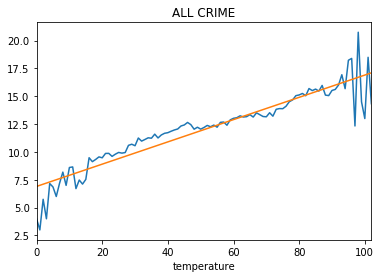

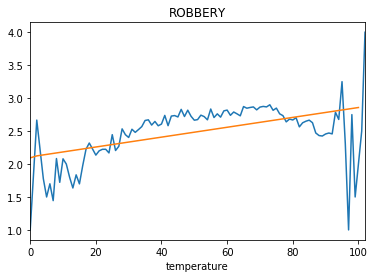

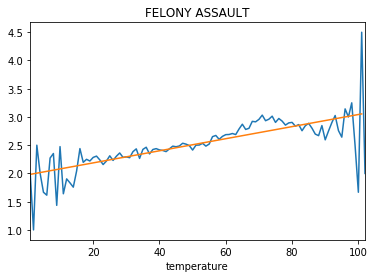

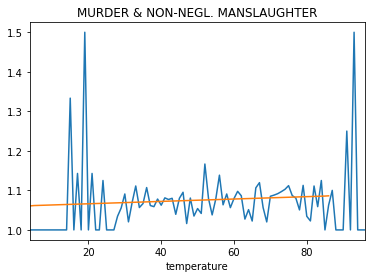

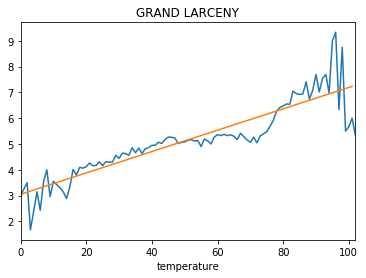

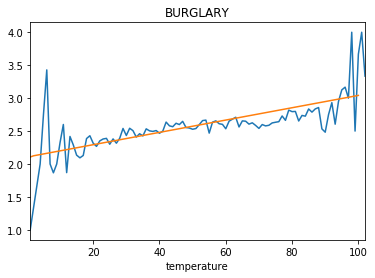

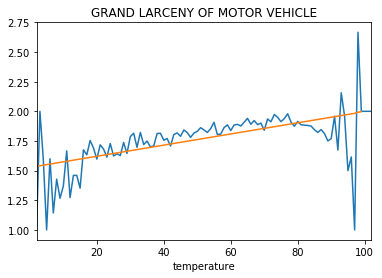

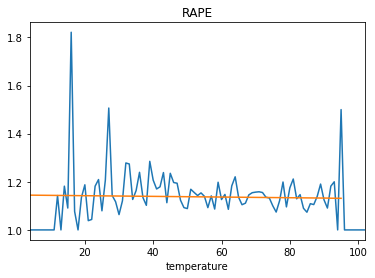

In [285]:
felonyTypes = ['ALL CRIME', 'ROBBERY', 'FELONY ASSAULT', 'MURDER & NON-NEGL. MANSLAUGHTER', 'GRAND LARCENY', 'BURGLARY',
                 'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE']

weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 
               'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'temperature')



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     354.3
Date:                Sun, 08 Apr 2018   Prob (F-statistic):           1.20e-33
Time:                        17:38:37   Log-Likelihood:                -109.04
No. Observations:                  96   AIC:                             222.1
Df Residuals:                      94   BIC:                             227.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     10.



BURGLARY Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     70.78
Date:                Sun, 08 Apr 2018   Prob (F-statistic):           4.62e-13
Time:                        17:38:39   Log-Likelihood:                 20.462
No. Observations:                  95   AIC:                            -36.92
Df Residuals:                      93   BIC:                            -31.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.3

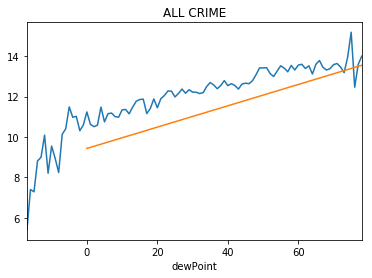

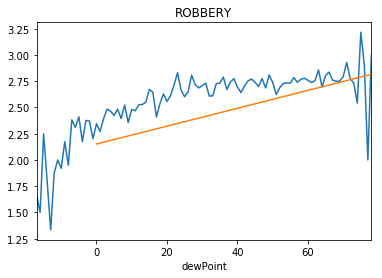

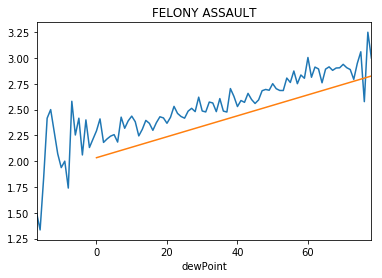

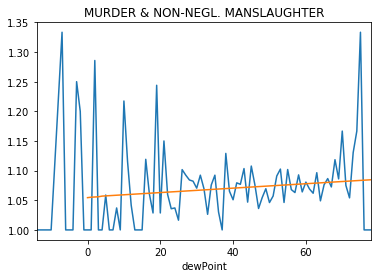

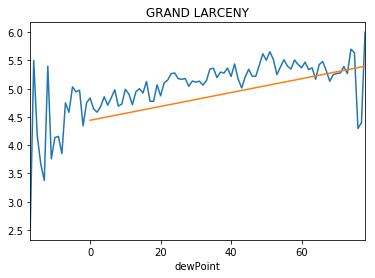

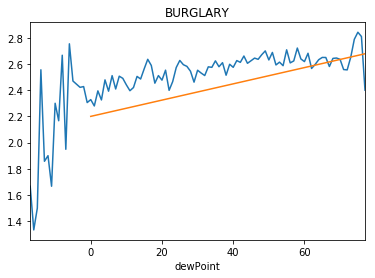

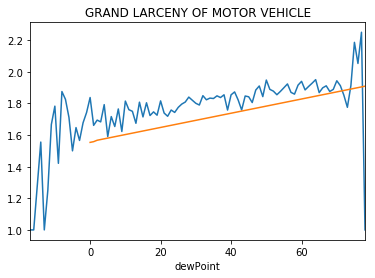

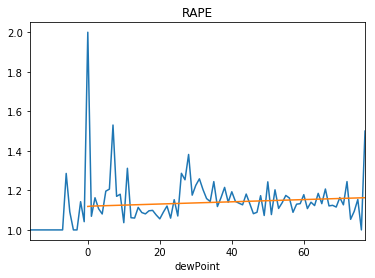

In [288]:
for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'dewPoint')